In [1]:
import os
os.chdir(r"c:\Users\ASUS\OneDrive\Desktop\BTP PROJECT\BTP_Implementation\iiot-hybrid-detection")
print("CWD:", os.getcwd())

CWD: c:\Users\ASUS\OneDrive\Desktop\BTP PROJECT\BTP_Implementation\iiot-hybrid-detection


In [2]:
# --- Imports ---
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from src.data_pipeline import build_preprocessing_pipeline
from src.constants import DATA_PATH, TARGET_COL, SEED

# Make sure results dirs exist
os.makedirs("results/models", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)


In [3]:
# --- Load dataset ---
df = pd.read_csv(DATA_PATH)

# --- Encode labels ---
le = LabelEncoder()
y = le.fit_transform(df[TARGET_COL])
X = df.drop(columns=[TARGET_COL])

# Save encoder
joblib.dump(le, "results/models/label_encoder.joblib")

# --- Train/validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# --- Preprocessing pipeline ---
preproc, num_cols, cat_cols = build_preprocessing_pipeline(df, TARGET_COL)

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)


Train shape: (168834, 43) Validation shape: (42209, 43)


In [4]:
models = {
    "LogReg": LogisticRegression(max_iter=200, random_state=SEED),
    "DecisionTree": DecisionTreeClassifier(random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    "SVM": SVC(kernel="rbf", probability=True, random_state=SEED),
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=6, random_state=SEED,
        n_jobs=-1, tree_method="hist"   # CPU mode
    )
}



=== Training LogReg ===


h:\ML krish naik Udemy\Coding\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


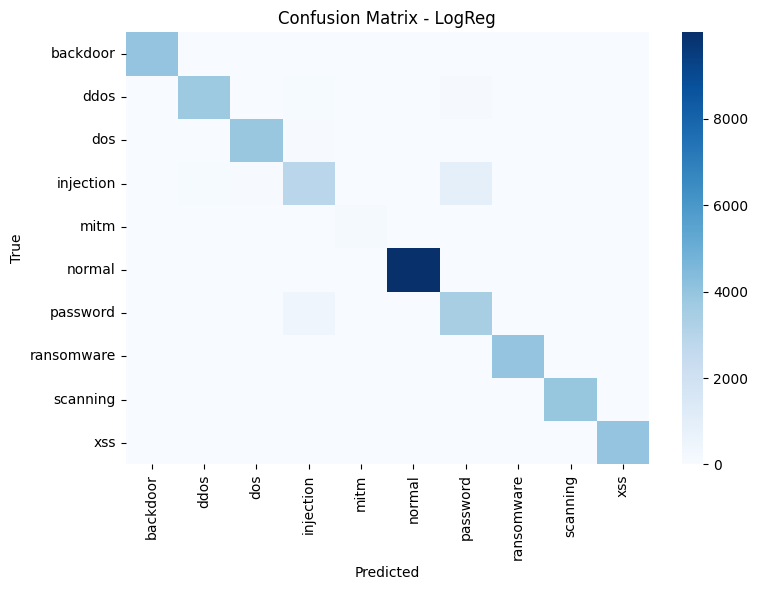


=== Training DecisionTree ===


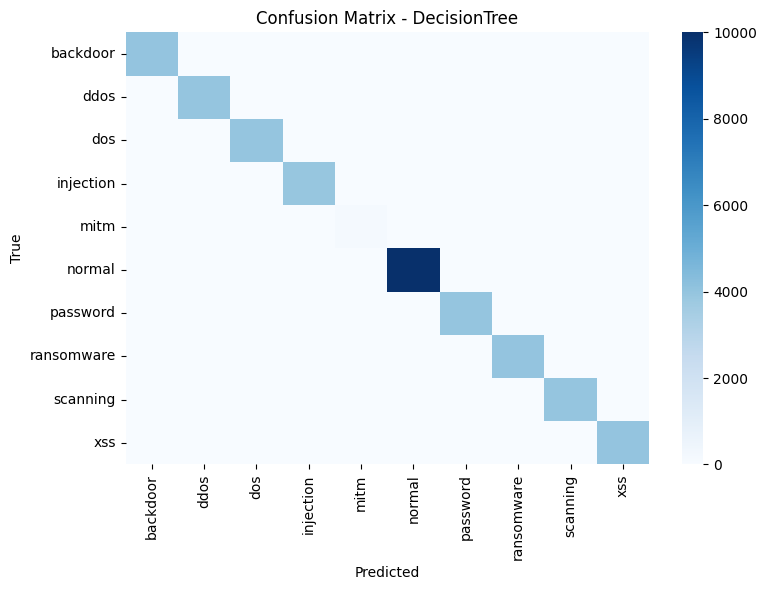


=== Training RandomForest ===


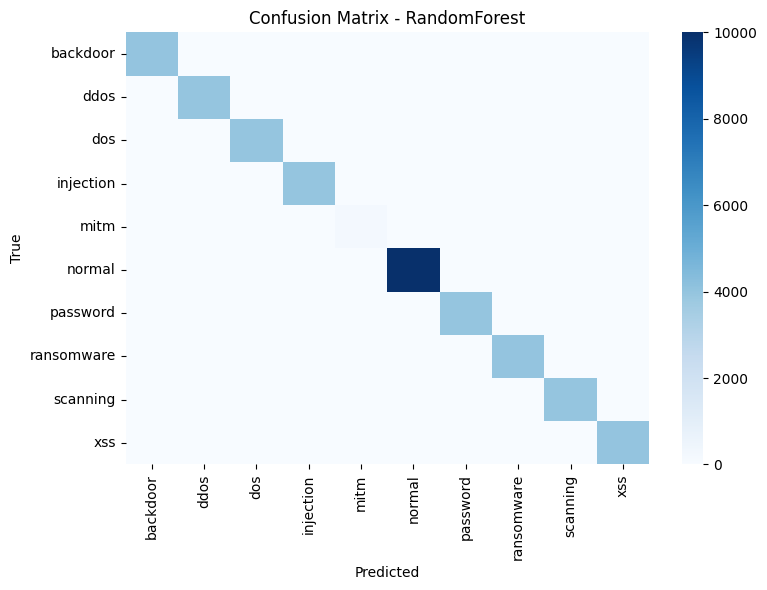


=== Training SVM ===


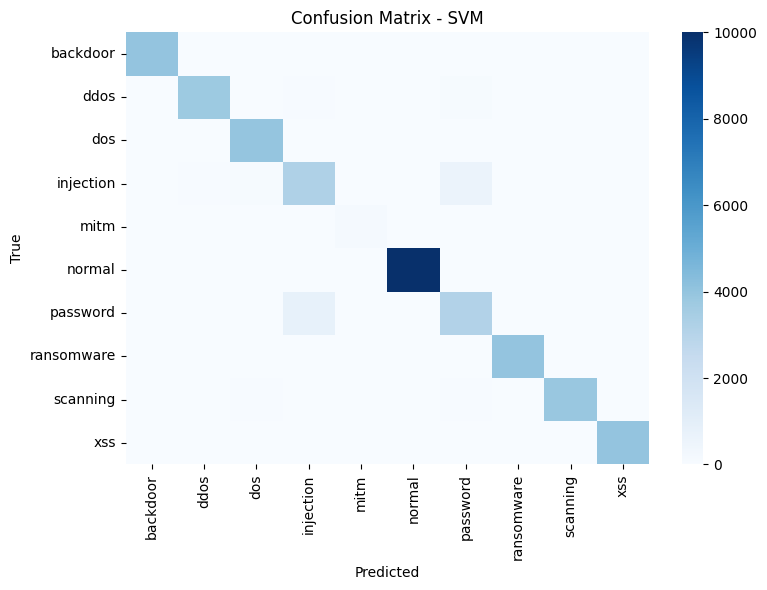


=== Training XGBoost ===


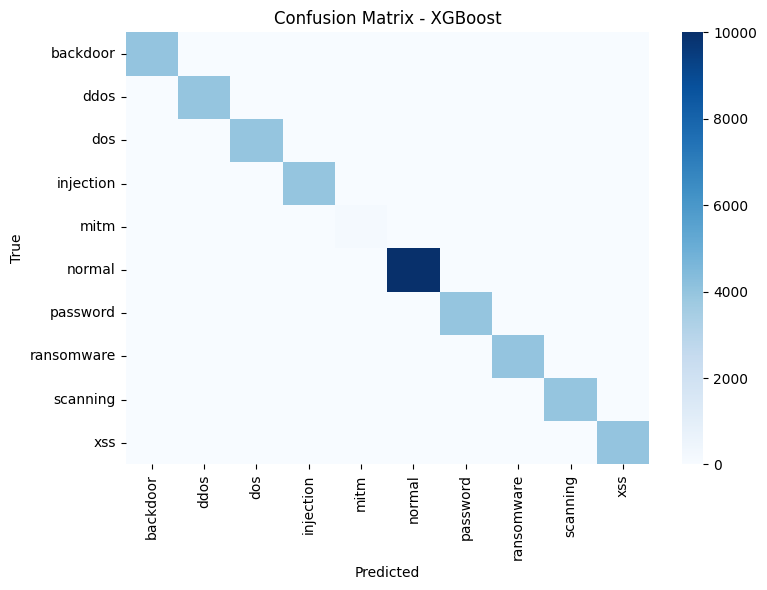

In [6]:
results = []

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    pipeline = Pipeline([
        ("preproc", preproc),
        ("clf", model)
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)

    # --- Classification Report ---
    report = classification_report(
        y_val, preds, target_names=le.classes_, output_dict=True
    )
    results.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    })

    # --- Save Model ---
    joblib.dump(pipeline, f"results/models/{name}_pipeline.joblib")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"results/plots/confmat_{name}.png")
    plt.show()


In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv("results/supervised_report.csv", index=False)
display(results_df)
